# Projet WaveStone :

#### Objectif : Prédictions des ventes dans les magasins

### Description de la base de données

- Id - an Id that represents a (Store, Date) duple within the test set

- Store - a unique Id for each store

- Sales - the turnover for any given day

- Customers - the number of customers on a given day

- Open - an indicator for whether the store was open: 0 = closed, 1 = open

- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

- StoreType - differentiates between 4 different store models: a, b, c, d

- Assortment - describes an assortment level: a = basic, b = extra, c = extended

- CompetitionDistance - distance in meters to the nearest competitor store

- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

- Promo - indicates whether a store is running a promo on that day

- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1 - Importation des libraires

In [57]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno
import itertools
from scipy import stats
%matplotlib inline

## 2 - Chargement de données

In [58]:
train = pd.read_csv("train.csv")
store = pd.read_csv("store.csv")

## 3 - Analyse exploratoire de données

### 3.1 - Transformations et statistiques

In [59]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [60]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [61]:
print(" Le nombre des magasins fermés certains jours : {}".format(train[(train.Open == 0)].count()[0]))  
print(" dont pour uniquement vacances scolaires : {}".format(train[(train.Open == 0) & (train.SchoolHoliday == 1) & (train.StateHoliday == '0')].count()[0]))    
print(" et pour StateHolidays (hors vacances scolaires) : {}".format(train[(train.Open == 0) & (train.SchoolHoliday == 0 ) & (train.StateHoliday == 'a') | (train.StateHoliday == 'b') |  (train.StateHoliday == 'c')].count()[0]))  
print(" et pour StateHolidays (vacances scolaires comprises) : {}".format(train[(train.Open == 0) & (train.StateHoliday == 'a') | (train.StateHoliday == 'b') |  (train.StateHoliday == 'c')].count()[0]))  
print(" et pour aucune de ces raisons : {} ".format(train[(train.Open == 0) & (train. StateHoliday == '0') & (train.SchoolHoliday == 0)].count()[0])) 

 Le nombre des magasins fermés certains jours : 172817
 dont pour uniquement vacances scolaires : 2263
 et pour StateHolidays (hors vacances scolaires) : 25255
 et pour StateHolidays (vacances scolaires comprises) : 30356
 et pour aucune de ces raisons : 121482 


In [62]:
# Transformation de Date en format datetime
train['year'] = train['Date'].apply(lambda x: x.split("-")[0])
train['month'] = train['Date'].apply(lambda x: x.split("-")[1])
train['day'] = train['Date'].apply(lambda x: x.split("-")[2])
train['DateTime'] = pd.to_datetime(train[['year','month', 'day']])
train = train.drop(['Date'],axis=1)

In [63]:
train.dtypes

Store                     int64
DayOfWeek                 int64
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
year                     object
month                    object
day                      object
DateTime         datetime64[ns]
dtype: object

In [64]:
# On supprime toutes les lignes qui correspondent à des magasins fermés avec 0 ventes
#train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

### 3.2 - Statistiques sur les valeurs manquantes

In [65]:
# Statistiques 
total = train.isnull().sum().sort_values(ascending = False)
percent = round(train.isnull().sum().sort_values(ascending = False)/len(train)*100, 2)
pd.concat([total, percent], axis = 1,keys= ['Total', 'Percent'])

,Total,Percent
DateTime,0,0.0
day,0,0.0
month,0,0.0
year,0,0.0
SchoolHoliday,0,0.0
StateHoliday,0,0.0
Promo,0,0.0
Open,0,0.0
Customers,0,0.0
Sales,0,0.0


In [66]:
total = store.isnull().sum().sort_values(ascending = False)
percent = round(store.isnull().sum().sort_values(ascending = False)/len(store)*100, 2)
pd.concat([total, percent], axis = 1,keys= ['Total', 'Percent'])

,Total,Percent
PromoInterval,544,48.79
Promo2SinceYear,544,48.79
Promo2SinceWeek,544,48.79
CompetitionOpenSinceYear,354,31.75
CompetitionOpenSinceMonth,354,31.75
CompetitionDistance,3,0.27
Promo2,0,0.00
Assortment,0,0.00
StoreType,0,0.00
Store,0,0.00


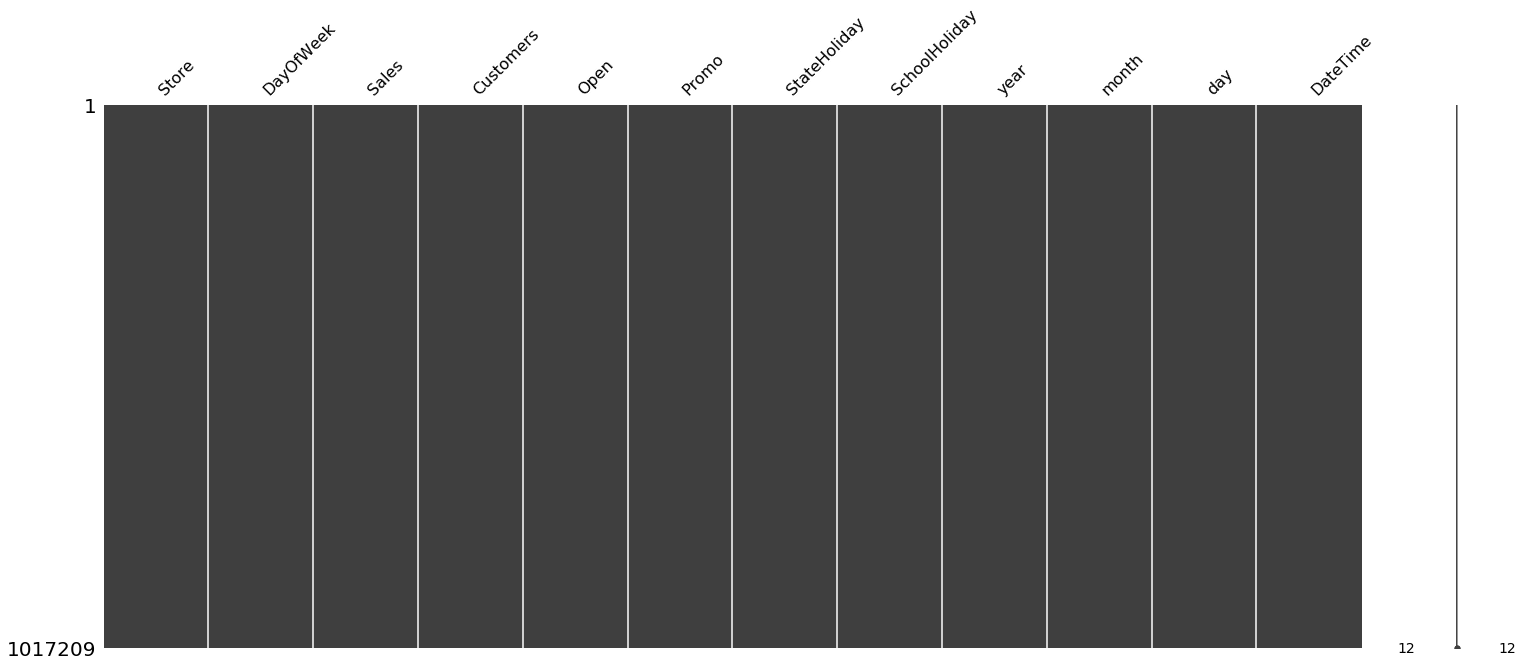

In [67]:
msno.matrix(train)

### 3.3 - Remplacer les valeurs manquantes

In [68]:
# Quand on a pas de promo2, il n'y a pas de Promo2SinceYear et Promo2SinceWeek, on met les valeurs à 0
store.Promo2SinceYear[store.Promo2 == 0]= int(0)
store.Promo2SinceWeek[store.Promo2 == 0]= int(0)
store.PromoInterval[store.Promo2 == 0]= int(0)

# On remplace par la médiane les valeurs dans CompetitionOpenSinceMonth/Year
store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].median(), inplace = True)
store['CompetitionOpenSinceYear'].fillna(store['CompetitionOpenSinceYear'].median(), inplace = True)


In [69]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)


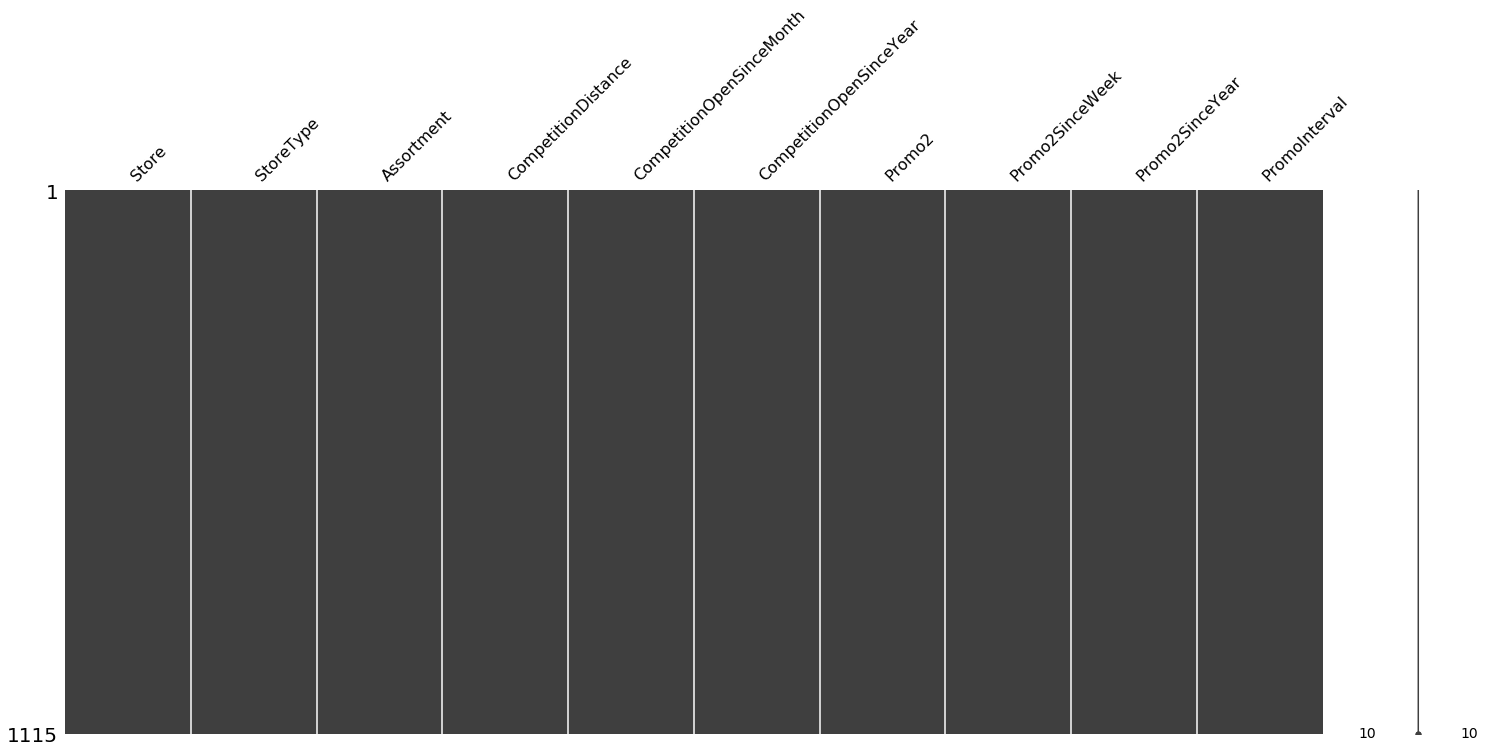

In [70]:
msno.matrix(store)

### 3.4 - Transformer les valeurs qualitatives par des valeurs quantitatives

In [71]:
store_modalites = store.copy()

store_modalites['StoreTypeA'] = 0
store_modalites['StoreTypeB'] = 0
store_modalites['StoreTypeC'] = 0
store_modalites['StoreTypeD'] = 0

store_modalites.StoreTypeA[store_modalites.StoreType == 'a']= 1
store_modalites.StoreTypeB[store_modalites.StoreType == 'b']= 1
store_modalites.StoreTypeC[store_modalites.StoreType == 'c']= 1
store_modalites.StoreTypeD[store_modalites.StoreType == 'd']= 1
store_modalites = store_modalites.drop('StoreType',axis=1)


store_modalites['AssortBasic'] = 0
store_modalites['AssortExtra'] = 0
store_modalites['AssortExtended'] = 0

store_modalites.AssortBasic[store_modalites.Assortment == 'a']= 1
store_modalites.AssortExtra[store_modalites.Assortment == 'b']= 1
store_modalites.AssortExtended[store_modalites.Assortment == 'c']= 1

store_modalites = store_modalites.drop('Assortment',axis=1)

store_modalites['PromoJan'] = 0
store_modalites['PromoFeb'] = 0
store_modalites['PromoMar'] = 0
store_modalites.PromoJan[store_modalites.PromoInterval == 'Jan,Apr,Jul,Oct']= 1
store_modalites.PromoFeb[store_modalites.PromoInterval == 'Feb,May,Aug,Nov']=1
store_modalites.PromoMar[store_modalites.PromoInterval == 'Mar,Jun,Sept,Dec']=1
store_modalites = store_modalites.drop(['PromoInterval'],axis=1)

train_modalites = train.copy()

train_modalites['StateHolidayNone'] = 0
train_modalites['StateHolidayA'] = 0
train_modalites['StateHolidayB'] = 0
train_modalites['StateHolidayC'] = 0

train_modalites.StateHolidayNone[train_modalites.StateHoliday == '0']= 1
train_modalites.StateHolidayA[train_modalites.StateHoliday == 'a']= 1
train_modalites.StateHolidayB[train_modalites.StateHoliday == 'b']= 1
train_modalites.StateHolidayC[train_modalites.StateHoliday == 'c']= 1
train_modalites = train_modalites.drop('StateHoliday',axis=1)

### 3.5 - Fusion des deux datasets

In [72]:
train_store_modalites = pd.merge(train_modalites, store_modalites, how = 'inner', on = 'Store')
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

### 3.6 - Visualisation de données

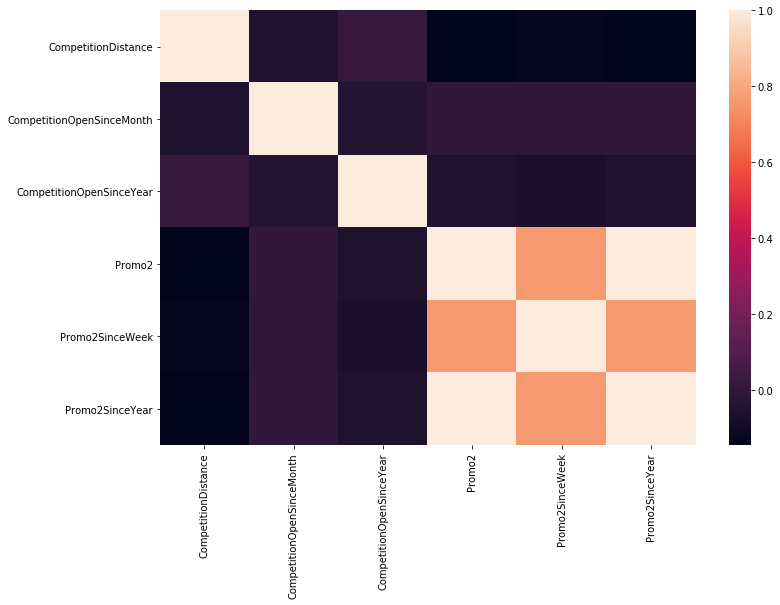

In [73]:
catcols = ['Store','StoreType','Assortment','PromoInterval']
numcols = [x for x in store.columns if x not in catcols]
plt.figure(figsize = (12,8))
sns.heatmap(data=store[numcols].corr())
plt.show()
plt.gcf().clear()

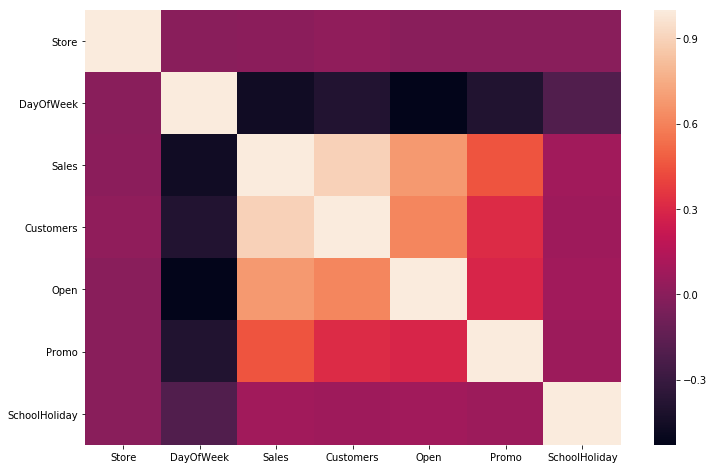

In [74]:
catcols = []
numcols = [x for x in train.columns if x not in catcols]
plt.figure(figsize = (12,8))
sns.heatmap(data=train[numcols].corr())
plt.show()
plt.gcf().clear()

In [75]:
train_store['SalesperCustomer'] = train_store['Sales']/train_store['Customers']
dts = train_store.copy()

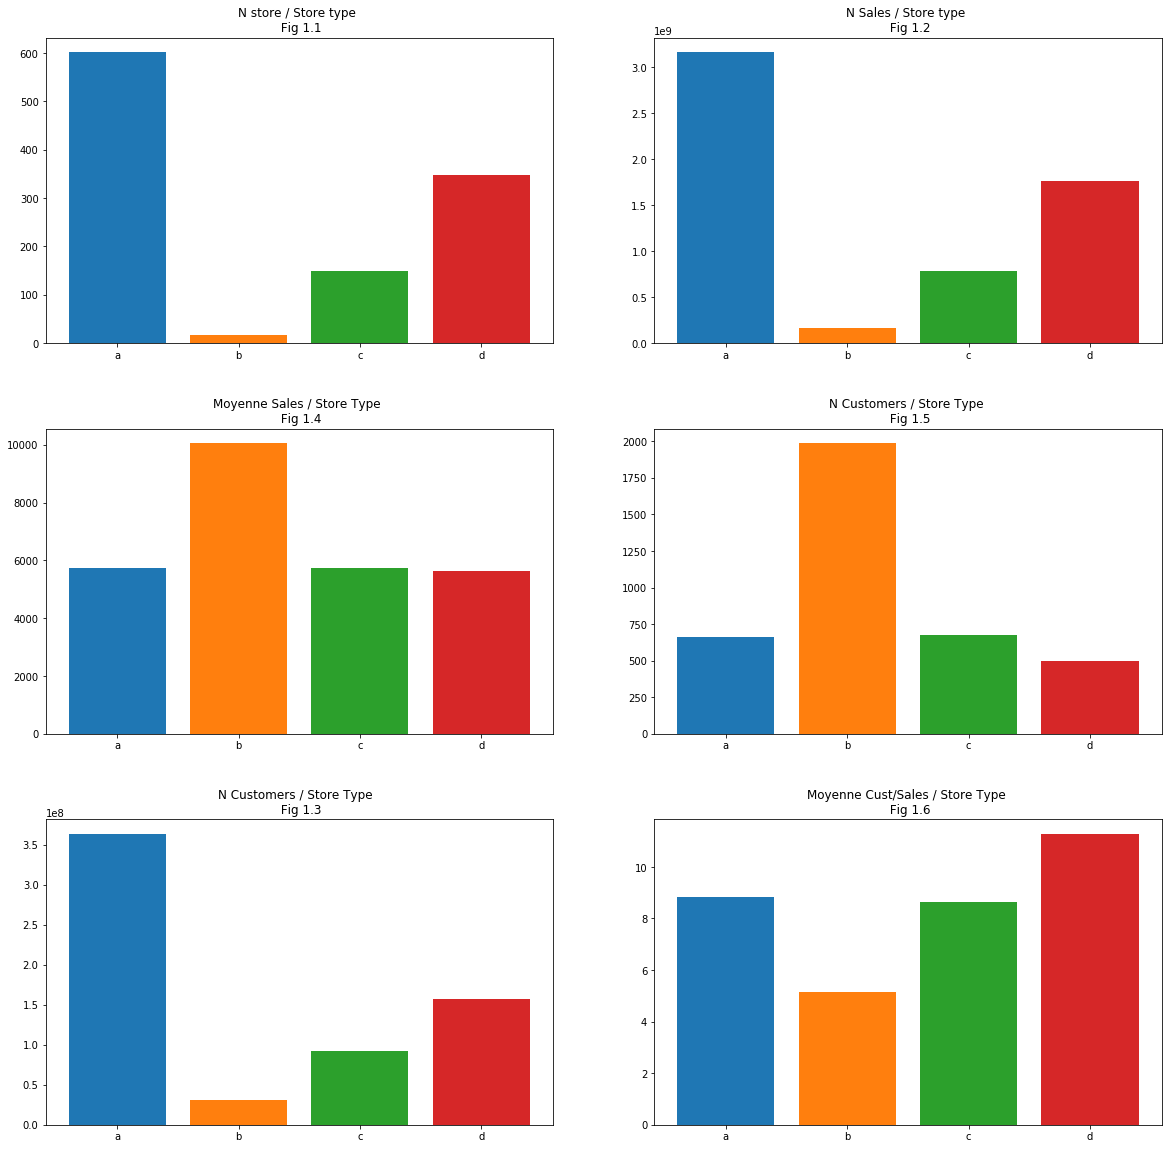

In [76]:
fig, axes = plt.subplots(3, 2,figsize=(20,20) )
palette = itertools.cycle(sns.color_palette(n_colors=4))
plt.subplots_adjust(hspace = 0.28)
#axes[1].df_train_store.groupby(by="StoreType").count().Store.plot(kind='bar')
axes[0,0].bar(store.groupby(by="StoreType").count().Store.index,store.groupby(by="StoreType").count().Store,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,0].set_title("N store / Store type \n Fig 1.1")
axes[0,1].bar(dts.groupby(by="StoreType").sum().Sales.index,dts.groupby(by="StoreType").sum().Sales,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,1].set_title("N Sales / Store type \n Fig 1.2")
axes[2,0].bar(dts.groupby(by="StoreType").sum().Customers.index,dts.groupby(by="StoreType").sum().Customers,color=[next(palette),next(palette),next(palette),next(palette)])
axes[2,0].set_title("N Customers / Store Type  \n Fig 1.3")
axes[1,0].bar(dts.groupby(by="StoreType").sum().Customers.index,dts.groupby(by="StoreType").Sales.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,0].set_title("Moyenne Sales / Store Type \n Fig 1.4")
axes[1,1].bar(dts.groupby(by="StoreType").sum().Customers.index,dts.groupby(by="StoreType").Customers.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,1].set_title("N Customers / Store Type \n Fig 1.5")
axes[2,1].bar(dts.groupby(by="StoreType").sum().Sales.index,dts.groupby(by="StoreType").SalesperCustomer.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[2,1].set_title("Moyenne Cust/Sales / Store Type \n Fig 1.6")
plt.show()

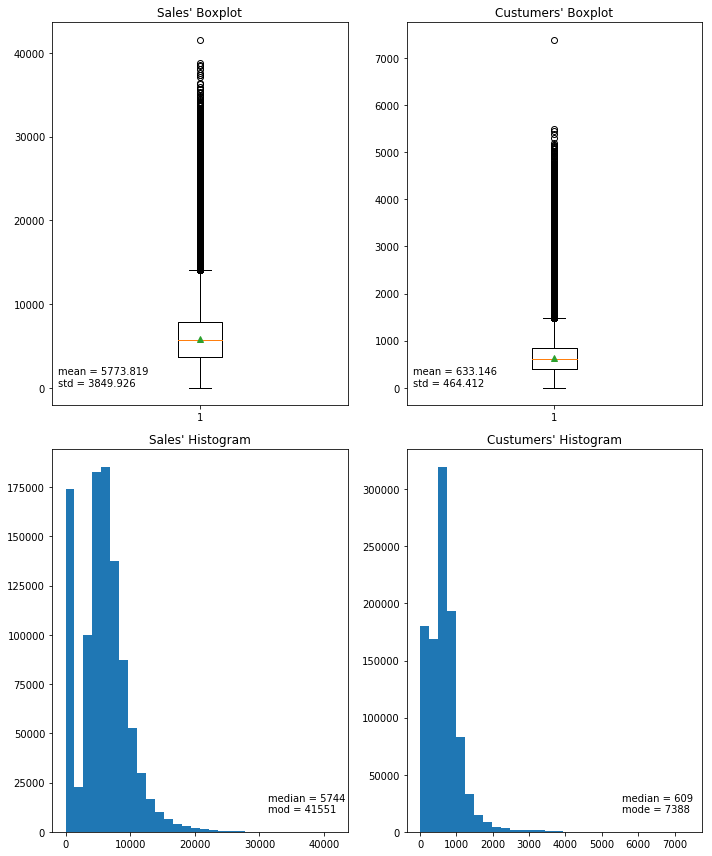

In [124]:
fig,axs=plt.subplots(2,2, figsize=(10,12))

bp1=axs[0,0].boxplot(train.Sales, showmeans=True)
axs[0,0].set_title("Sales' Boxplot")
axs[0,0].annotate("mean = %.3f\nstd = %.3f"%(train.Sales.mean(),train.Sales.std()),
                  xy=(0.02, 0.05), xycoords='axes fraction')

bp2=axs[0,1].boxplot(train.Customers, showmeans=True)
axs[0,1].set_title("Custumers' Boxplot")
axs[0,1].annotate("mean = %.3f\nstd = %.3f"%(train.Customers.mean(),train.Customers.std()),
                  xy=(0.02, 0.05), xycoords='axes fraction')

hi1=axs[1,0].hist(train.Sales,bins=30)
axs[1,0].set_title("Sales' Histogram")
axs[1,0].annotate("median = %d\nmod = %d"%(train.Sales.median(),train.Sales.max()),
                  xy=(0.73, 0.05), xycoords='axes fraction')

hi2=axs[1,1].hist(train.Customers,bins=30)
axs[1,1].set_title("Custumers' Histogram")
axs[1,1].annotate("median = %d\nmode = %d"%(train.Customers.median(),train.Customers.max()),
                  xy=(0.73, 0.05), xycoords='axes fraction')

fig.tight_layout()

In [78]:
print("pourcentage du nombre de clients > 2000 : {}".format(train[train.Customers>2000].count()[0]/train.shape[0] * 100))

pourcentage du nombre de clients > 2000 : 1.4482766078554161


In [79]:
stats.pearsonr(train.Sales , train.Customers)

(0.8947107733017011, 0.0)

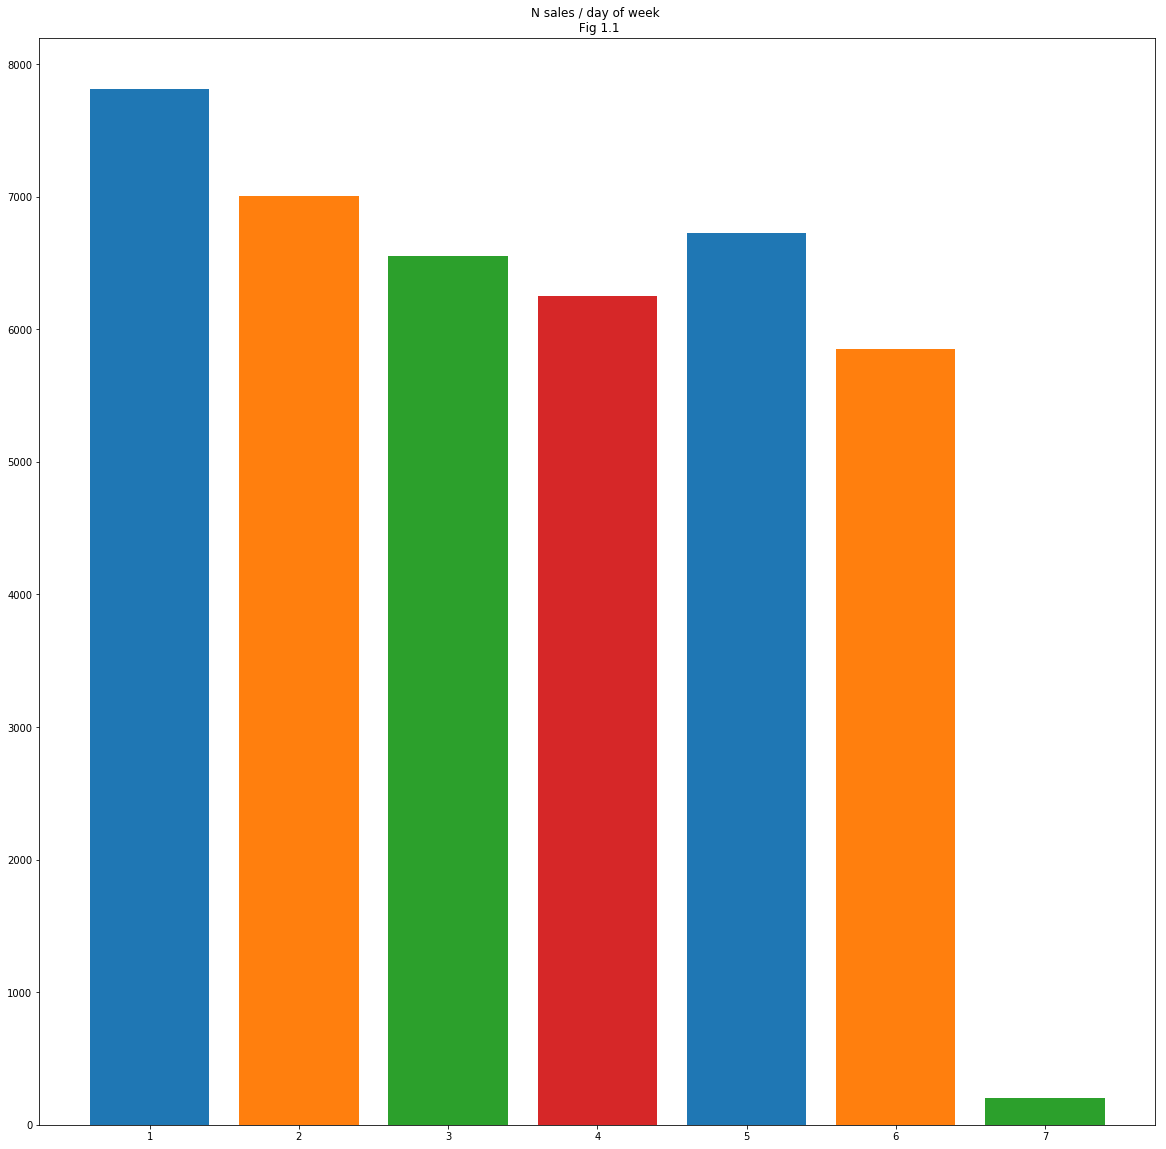

In [80]:
fig, axes = plt.subplots(1, 1,figsize=(20,20) )
palette = itertools.cycle(sns.color_palette(n_colors=4))
plt.subplots_adjust(hspace = 0.28)
#axes[1].df_train_store.groupby(by="StoreType").count().Store.plot(kind='bar')
axes.bar(dts.groupby(by="DayOfWeek").mean().Sales.index,dts.groupby(by="DayOfWeek").mean().Sales,color=[next(palette),next(palette),next(palette),next(palette)])
axes.set_title("N sales / day of week \n Fig 1.1")
plt.show()

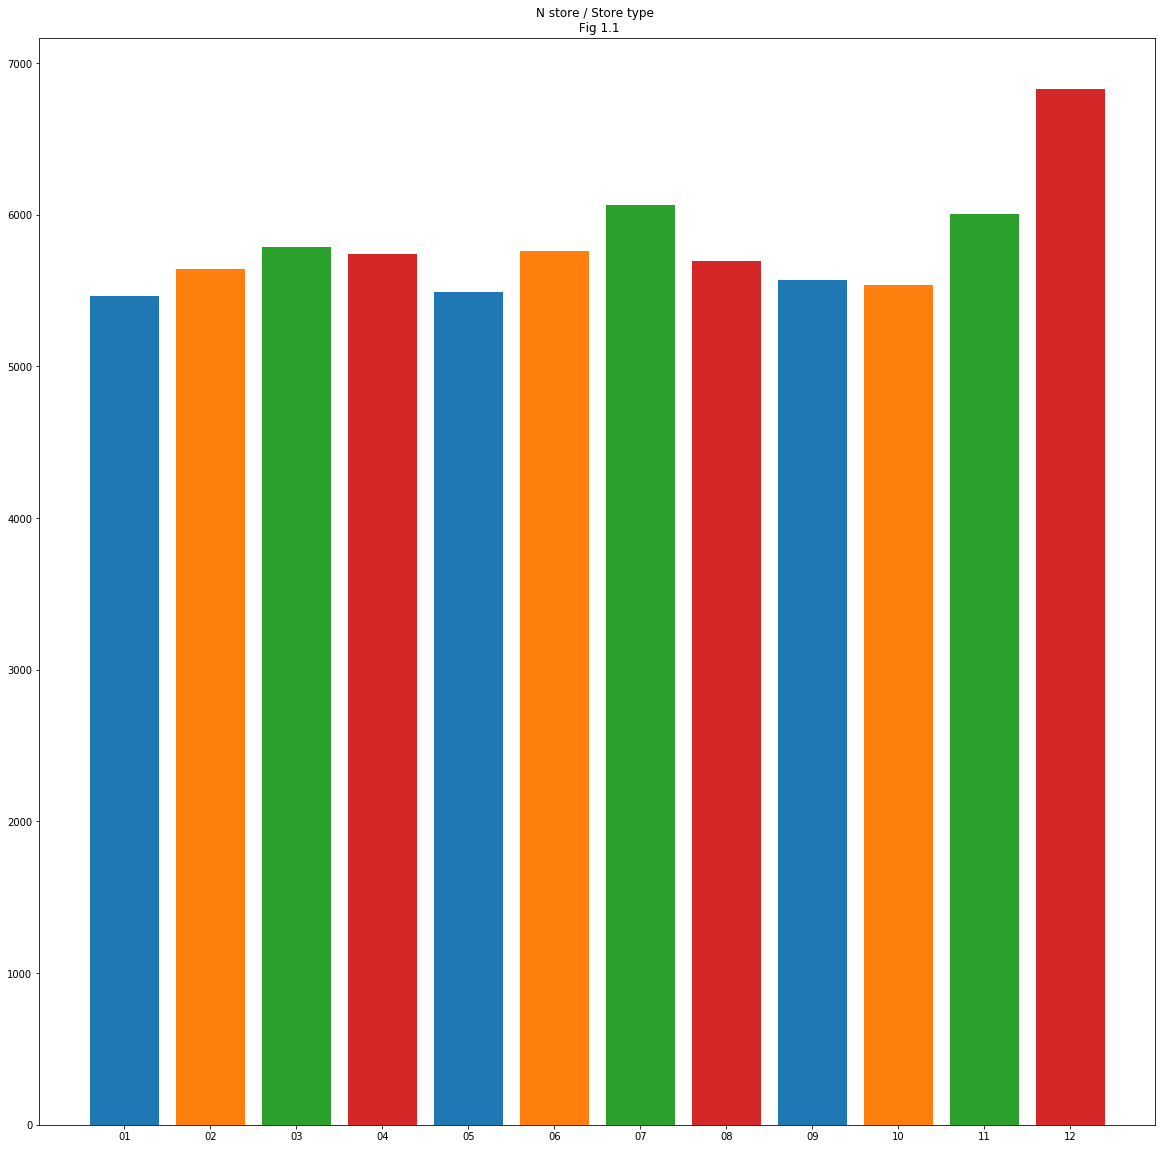

In [81]:
fig, axes = plt.subplots(1, 1,figsize=(20,20) )
palette = itertools.cycle(sns.color_palette(n_colors=4))
plt.subplots_adjust(hspace = 0.28)
#axes[1].df_train_store.groupby(by="StoreType").count().Store.plot(kind='bar')
axes.bar(dts.groupby(by="month").mean().Sales.index,dts.groupby(by="month").mean().Sales,color=[next(palette),next(palette),next(palette),next(palette)])
axes.set_title("N store / Store type \n Fig 1.1")
plt.show()

In [126]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

NameError: name 'c' is not defined

## 4 - Modèles Machine learning

In [82]:
train_sorted_modalites = train_store_modalites.sort_values(by='DateTime')
train_sorted_modalites = train_sorted_modalites.drop('Customers',axis=1)
y = train_sorted_modalites['Sales']
X = train_sorted_modalites.drop(['Sales','year','month', 'day'],axis=1)

In [95]:
X_train = X.iloc[:int(len(X)*0.8)]
y_train = y.iloc[:int(len(X)*0.8)]
X_test = X.iloc[int(len(X)*0.8):]
y_test = y.iloc[int(len(X)*0.8):]
X_train = X_train.drop('DateTime',axis=1)
X_test = X_test.drop('DateTime',axis=1)

In [96]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

0.5899360846976005

In [98]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=27, random_state=1,n_estimators=8)
regr.fit(X_train, y_train)

0.9337538431393004

In [125]:
from sklearn.metrics import mean_squared_error
msereg = mean_squared_error(y_test, reg.predict(X_test))
mseregr = mean_squared_error(y_test, regr.predict(X_test))
print("RMSE regression lineaire : ",np.sqrt(msereg))
print("RMSE foret regression lineaire : ",np.sqrt(mseregr))

RMSE regression lineaire :  2474.555146319163
RMSE foret regression lineaire :  994.6074408374584
